In [123]:
# Converted from notebook: compas_analysis.ipynb

#!/usr/bin/env python
# coding: utf-8

# # Compas Analysis



In [124]:


get_ipython().system('pip install pandas numpy matplotlib seaborn statsmodels -q')

from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

sns.set(style="whitegrid")





[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [125]:


raw_data = pd.read_csv("dataset/compas-scores-two-years.csv")
print(f"Total rows number: {len(raw_data)}")




Total rows number: 7214


In [126]:


df = raw_data.loc[:, [
    'age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex',
    'priors_count', 'days_b_screening_arrest', 'decile_score',
    'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out',
    'compas_screening_date'    # ← add this
]]




In [127]:


df['screening_date'] = pd.to_datetime(df['compas_screening_date'])
cutoff = pd.Timestamp('2014-04-01')




In [128]:


df = df[df['screening_date'] <= cutoff].copy()
print(f"Rows after two-year cutoff: {len(df)}")




Rows after two-year cutoff: 6216


In [129]:


# We filter out rows for several reasons: (similar to the Propublica study)
# 1. Screening date not within ±30 days of arrest  
# 2. Missing recidivism flag (`is_recid == -1`)  
# 3. Non-jailable offenses (`c_charge_degree == 'O'`)  
# 4. Missing COMPAS score text (`score_text == 'N/A'`)  
# 5. Only individuals with either two-year recidivism or ≥2 years out of jail




In [130]:


df = df[
    df['days_b_screening_arrest'].between(-30, 30) &
    (df['is_recid'] != -1) &
    (df['c_charge_degree'] != 'O') &
    (df['score_text'] != 'N/A')
].copy()

print(f"Rows after filtering: {len(df)}")




Rows after filtering: 5304


In [131]:


#length of jail stay and its correlation with COMPAS decile score.

df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).dt.days

corr = df[['length_of_stay', 'decile_score']].corr().iloc[0,1]
print(f"Correlation between length_of_stay and decile_score: {corr:.4f}")


# After filtering we have the following demographic breakdown:



Correlation between length_of_stay and decile_score: 0.2115


In [132]:


print(df['age_cat'].value_counts(dropna=False))




age_cat
25 - 45            3031
Greater than 45    1165
Less than 25       1108
Name: count, dtype: int64


In [133]:


print(df['race'].value_counts(dropna=False))




race
African-American    2682
Caucasian           1829
Hispanic             448
Other                309
Asian                 27
Native American        9
Name: count, dtype: int64


In [134]:


total = len(df)
for race, count in df['race'].value_counts().items():
    print(f"{race}: {count/total*100:.2f}%")




African-American: 50.57%
Caucasian: 34.48%
Hispanic: 8.45%
Other: 5.83%
Asian: 0.51%
Native American: 0.17%


In [135]:


print(df['score_text'].value_counts())




score_text
Low       3086
Medium    1329
High       889
Name: count, dtype: int64


In [136]:


print(pd.crosstab(df['sex'], df['race']))




race    African-American  Asian  Caucasian  Hispanic  Native American  Other
sex                                                                         
Female               474      1        414        73                2     53
Male                2208     26       1415       375                7    256


In [137]:


sex_counts = df['sex'].value_counts()
for sex, count in sex_counts.items():
    print(f"{sex}: {count/total*100:.2f}%")




Male: 80.83%
Female: 19.17%


In [138]:


recid_count = df['two_year_recid'].sum()
print(f"\nNumber of recidivists: {recid_count}")
print(f"Recidivism rate: {recid_count/total*100:.2f}%")





Number of recidivists: 1941
Recidivism rate: 36.60%


In [139]:


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.countplot(x='decile_score', data=df[df['race']=="African-American"],
              order=sorted(df['decile_score'].unique()),
              ax=axes[0])
axes[0].set_title("Black Defendants' Decile Scores")
axes[0].set_ylim(0, 650)

sns.countplot(x='decile_score', data=df[df['race']=="Caucasian"],
              order=sorted(df['decile_score'].unique()),
              ax=axes[1])
axes[1].set_title("White Defendants' Decile Scores")
axes[1].set_ylim(0, 650)

for ax in axes:
    ax.set_xlabel("Decile Score")
    ax.set_ylabel("Count")

plt.tight_layout()




In [140]:


pd.crosstab(df['decile_score'], df['race'])


# ## Racial Bias in Compas
# 
# We run a logistic regression predicting High vs. Low COMPAS score (`score_text != 'Low'`) as a function of gender, age category, race, number of priors, charge degree, and recidivism.



race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,338,14,570,146,0,136
2,316,4,277,77,2,53
3,264,4,214,64,1,28
4,288,0,214,43,0,33
5,265,1,168,31,0,17
6,262,2,133,23,2,17
7,280,0,93,25,2,8
8,246,2,66,12,0,4
9,256,0,59,17,1,6


In [141]:


df['high_score'] = (df['score_text'] != 'Low').astype(int)




In [142]:


df['race_cat'] = pd.Categorical(
    df['race'],
    categories=[
        'Caucasian',
        'African-American',
        'Asian',
        'Hispanic',
        'Native American',
        'Other'
    ],
    ordered=False
)

model = smf.logit(
    formula=(
        "high_score ~ "
        "C(sex) + "
        "C(age_cat) + "
        "C(race_cat, Treatment(reference='Caucasian')) + "
        "priors_count + "
        "C(c_charge_degree) + "
        "two_year_recid"
    ),
    data=df
).fit(disp=False)




In [143]:


# Extract the corrected coefficients:
intercept    = model.params['Intercept']
beta_black   = model.params["C(race_cat, Treatment(reference='Caucasian'))[T.African-American]"]
beta_male    = model.params['C(sex)[T.Male]']
beta_under25 = model.params['C(age_cat)[T.Less than 25]']

# Baseline probability for the reference group (Caucasian female, age 25–45, 0 priors, no recid)
p0 = np.exp(intercept) / (1 + np.exp(intercept))
print(f"Baseline P(high_score): {p0:.3f}")

# Adjusted probability ratios
def adj_ratio(beta):
    num = np.exp(beta)
    return num / (1 - p0 + p0 * num)

print(f"African-American vs. White ratio: {adj_ratio(beta_black):.3f}")
print(f"Male vs. Female ratio:           {adj_ratio(beta_male):.3f}")
print(f"<25 vs. 25–45 ratio:             {adj_ratio(beta_under25):.3f}")


# - **African-American vs. White**: Black defendants are **1.43×** as likely as White defendants to receive a High score (≈ 42.5 % higher probability).  
# - **Male vs. Female**: Male defendants are **0.84×** as likely as female defendants to get a High score (≈ 16.3 % lower probability).  
# - **Under 25 vs. 25–45**: Defendants under 25 are **2.35×** as likely as 25–45-year-olds to be classified High Risk (≈ 134.7 % higher probability).  
# 

# # Chapter 2: Exploratory Data Analysis (EDA)
# 

# ## 1. Summary Statistics



Baseline P(high_score): 0.209
African-American vs. White ratio: 1.440
Male vs. Female ratio:           0.831
<25 vs. 25–45 ratio:             2.430


In [144]:


# Compute descriptive statistics for selected numeric columns using quantiles
num_cols = ['age', 'priors_count', 'decile_score', 'length_of_stay']
summary_stats = pd.DataFrame({
    'mean': df[num_cols].mean(),
    'median': df[num_cols].median(),
    'std': df[num_cols].std(),
    'min': df[num_cols].min(),
    '25%': df[num_cols].quantile(0.25),
    '50%': df[num_cols].quantile(0.5),
    '75%': df[num_cols].quantile(0.75),
    'max': df[num_cols].max()
}).T
summary_stats


# ## 2. Distribution Plots



,age,priors_count,decile_score,length_of_stay
mean,34.953431,2.993590,4.240196,14.740950
median,32.000000,1.000000,4.000000,1.000000
std,11.817771,4.458153,2.801026,47.888538
min,19.000000,0.000000,1.000000,-1.000000
25%,25.000000,0.000000,2.000000,0.000000
50%,32.000000,1.000000,4.000000,1.000000
75%,43.000000,4.000000,6.000000,5.000000
max,96.000000,37.000000,10.000000,799.000000


<Figure size 640x480 with 0 Axes>

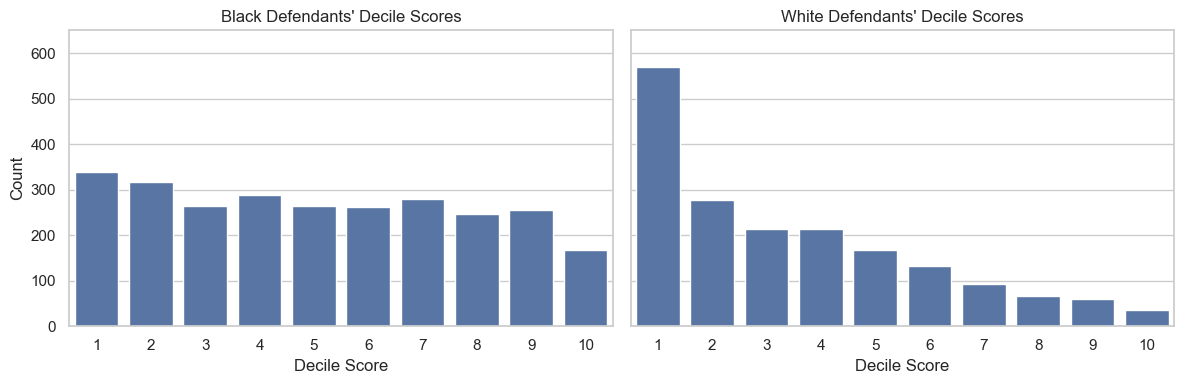

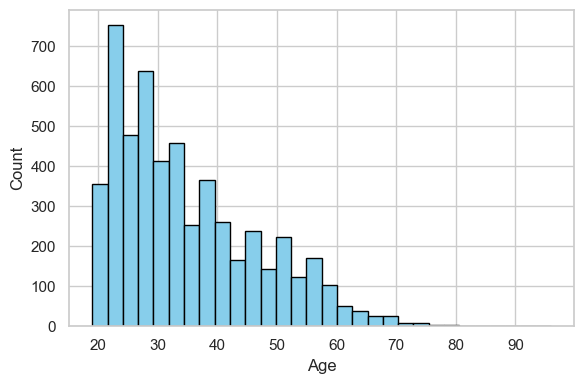

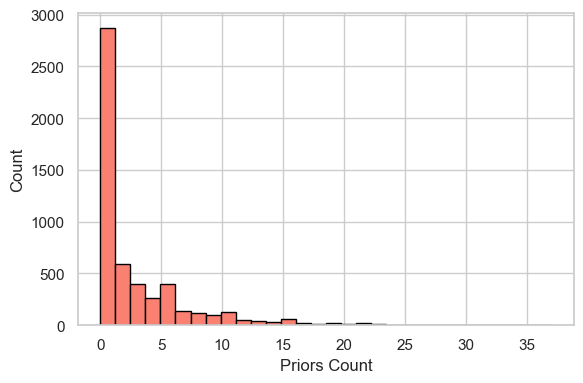

In [145]:


import os

os.makedirs("figures", exist_ok=True)

# Histogram for age
plt.figure(figsize=(6,4))
plt.hist(df['age'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.tight_layout()
plt.savefig(f"figures/age_hist.jpg", dpi=400)
plt.show()

# %%
# Histogram for priors_count
plt.figure(figsize=(6,4))
plt.hist(df['priors_count'], bins=30, color='salmon', edgecolor='black')
plt.xlabel('Priors Count')
plt.ylabel('Count')
plt.tight_layout()
plt.tight_layout()
plt.savefig(f"figures/priors_count_hist.jpg", dpi=400)
plt.show()


# ## 3. Categorical Counts



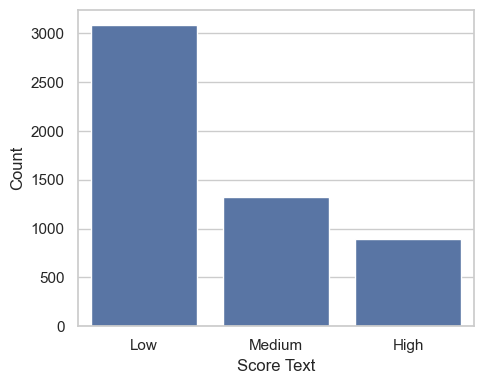

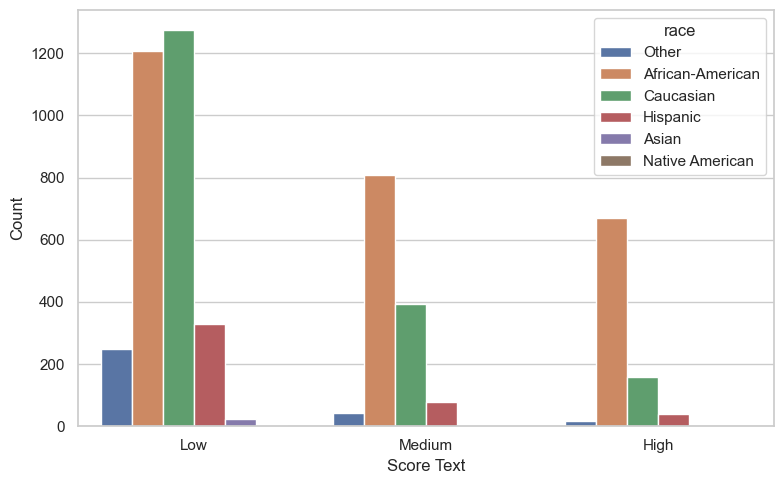

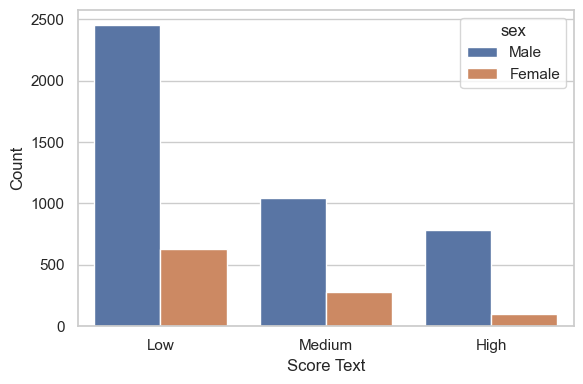

In [146]:


# Countplot for score_text overall
plt.figure(figsize=(5,4))
sns.countplot(x='score_text', data=df, order=['Low', 'Medium', 'High'])
plt.xlabel('Score Text')
plt.ylabel('Count')
plt.tight_layout()
plt.tight_layout()
plt.savefig(f"figures/score_text_count.jpg", dpi=400)
plt.show()

# %%
# Countplot for score_text by race
plt.figure(figsize=(8,5))
sns.countplot(x='score_text', hue='race', data=df, order=['Low', 'Medium', 'High'])
plt.xlabel('Score Text')
plt.ylabel('Count')
plt.tight_layout()
plt.tight_layout()
plt.savefig(f"figures/score_text_by_race.jpg", dpi=400)
plt.show()

# %%
# Countplot for score_text by sex
plt.figure(figsize=(6,4))
sns.countplot(x='score_text', hue='sex', data=df, order=['Low', 'Medium', 'High'])
plt.xlabel('Score Text')
plt.ylabel('Count')
plt.tight_layout()
plt.tight_layout()
plt.savefig(f"figures/score_text_by_sex.jpg", dpi=400)
plt.show()


# ## 4. Grouped Recidivism Rates



In [147]:


# Recidivism rate by race
recid_by_race = df.groupby('race')['two_year_recid'].mean().sort_values(ascending=False)
print("Recidivism Rate by Race:")
print(recid_by_race)

# %%
# Recidivism rate by age_cat
recid_by_age = df.groupby('age_cat')['two_year_recid'].mean().sort_values(ascending=False)
print("Recidivism Rate by Age Category:")
print(recid_by_age)

# %%
# Recidivism rate by c_charge_degree
recid_by_charge = df.groupby('c_charge_degree')['two_year_recid'].mean().sort_values(ascending=False)
print("Recidivism Rate by Charge Degree:")
print(recid_by_charge)


# # Chapter 3: Predictive Modeling and Fairness Evaluation

# ## 1. Train/Test Split



Recidivism Rate by Race:
race
African-American    0.435496
Native American     0.333333
Caucasian           0.299617
Other               0.291262
Hispanic            0.285714
Asian               0.148148
Name: two_year_recid, dtype: float64
Recidivism Rate by Age Category:
age_cat
Less than 25       0.464801
25 - 45            0.376113
Greater than 45    0.245494
Name: two_year_recid, dtype: float64
Recidivism Rate by Charge Degree:
c_charge_degree
F    0.404676
M    0.300305
Name: two_year_recid, dtype: float64


In [148]:


import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

# Create directories if they don't exist
os.makedirs("figures", exist_ok=True)
os.makedirs("models", exist_ok=True)

# Get one-hot encodings for categorical features
categorical_features = pd.get_dummies(df[['race', 'sex', 'c_charge_degree']], drop_first=False)

# Create feature matrix
X = pd.concat([
    df[['decile_score', 'priors_count', 'age']],
    categorical_features
], axis=1)

# Define target variable
y = df['two_year_recid']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


# ## 2. Model Training



In [149]:


# Create and fit logistic regression model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)




LogisticRegression(solver='liblinear')

In [150]:


# Create and fit XGBoost model
print("\nTraining XGBoost model...")
# Added use_label_encoder=False to avoid a warning with recent xgboost versions
# Added eval_metric to specify for potential future use or suppress warnings
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
print("XGBoost model trained.")


# ## 3. Performance Metrics




Training XGBoost model...
XGBoost model trained.


/Users/albertsteenstrup/.pyenv/versions/3.12.9/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:44:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [151]:


#
# Predict probabilities on test set, then choose optimal threshold via max F1
y_proba_lr = model.predict_proba(X_test)[:, 1]
from sklearn.metrics import precision_recall_curve

prec_lr, rec_lr, thr_lr = precision_recall_curve(y_test, y_proba_lr)
f1_lr = 2 * prec_lr * rec_lr / (prec_lr + rec_lr + 1e-9)
best_idx_lr = f1_lr.argmax()
best_tau_lr = thr_lr[best_idx_lr]
print(f"Best threshold for Logistic Regression (max F1): {best_tau_lr:.3f}")
# Predict with optimal threshold
y_pred = (y_proba_lr >= best_tau_lr).astype(int)
y_pred_proba = y_proba_lr

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")




Best threshold for Logistic Regression (max F1): 0.330
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.65      0.72      1009
           1       0.55      0.74      0.63       583

    accuracy                           0.68      1592
   macro avg       0.68      0.70      0.68      1592
weighted avg       0.72      0.68      0.69      1592

ROC AUC: 0.7618


In [152]:


#
# Predict probabilities on test set with XGBoost, then choose optimal threshold via max F1
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
prec_xgb, rec_xgb, thr_xgb = precision_recall_curve(y_test, y_proba_xgb)
f1_xgb = 2 * prec_xgb * rec_xgb / (prec_xgb + rec_xgb + 1e-9)
best_idx_xgb = f1_xgb.argmax()
best_tau_xgb = thr_xgb[best_idx_xgb]
print(f"Best threshold for XGBoost (max F1): {best_tau_xgb:.3f}")
# Predict with optimal threshold
y_pred_xgb = (y_proba_xgb >= best_tau_xgb).astype(int)
y_pred_proba_xgb = y_proba_xgb

# Print classification report for XGBoost
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

# Compute ROC AUC for XGBoost
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"ROC AUC (XGBoost): {roc_auc_xgb:.4f}")

# Reproduce ProPublica's decile-threshold recidivism rule
df_test = df.loc[X_test.index]
y_pred_decile = (df_test['decile_score'] >= 5).astype(int)
from sklearn.metrics import classification_report, confusion_matrix

print("\nProPublica Recidivism Classification (decile_score >= 5):")
print(classification_report(y_test, y_pred_decile))

# Overall confusion matrix
cm = confusion_matrix(y_test, y_pred_decile)
print("Confusion Matrix (decile_score >= 5):")
print(cm)

# Confusion matrix and rates by race
print("\nConfusion Matrix and Error Rates by Race:")
for race in df_test['race'].unique():
    mask = df_test['race'] == race
    y_true_race = y_test[mask]
    y_pred_race = y_pred_decile[mask]
    if len(y_true_race) == 0:
        continue
    cm_r = confusion_matrix(y_true_race, y_pred_race, labels=[0,1])
    tn, fp, fn, tp = cm_r.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    print(f"{race}:")
    print(cm_r)
    print(f"  FPR: {fpr:.3f}, FNR: {fnr:.3f}\n")


# ## 4. ROC Curve



Best threshold for XGBoost (max F1): 0.286

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.80      0.60      0.69      1009
           1       0.52      0.73      0.61       583

    accuracy                           0.65      1592
   macro avg       0.66      0.67      0.65      1592
weighted avg       0.69      0.65      0.66      1592

ROC AUC (XGBoost): 0.7246

ProPublica Recidivism Classification (decile_score >= 5):
              precision    recall  f1-score   support

           0       0.77      0.70      0.73      1009
           1       0.55      0.63      0.59       583

    accuracy                           0.68      1592
   macro avg       0.66      0.67      0.66      1592
weighted avg       0.69      0.68      0.68      1592

Confusion Matrix (decile_score >= 5):
[[708 301]
 [216 367]]

Confusion Matrix and Error Rates by Race:
African-American:
[[262 183]
 [105 260]]
  FPR: 0.411, FNR: 0.288

Caucasian:
[[

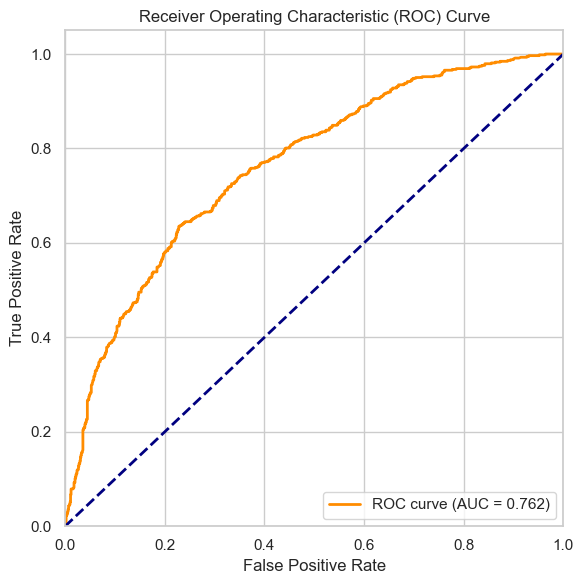

In [153]:


# Compute ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"figures/roc_curve.jpg", dpi=400)
plt.show()




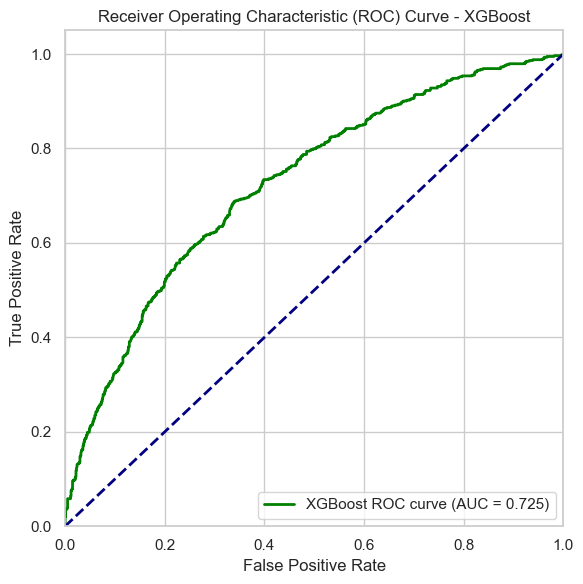

In [154]:


# Compute ROC curve points for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

# Plot ROC curve for XGBoost
plt.figure(figsize=(6, 6))
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost ROC curve (AUC = {roc_auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"figures/roc_curve_xgb.jpg", dpi=400)
plt.show()


# ## 5. Fairness Metrics by Race



In [155]:


# Create a DataFrame to store fairness metrics
fairness_metrics = []

# Get race values from test data (need to reconstruct from one-hot columns)
race_columns = [col for col in X_test.columns if col.startswith('race_')]
test_indices = X_test.index

# Recreate race column for test set
test_with_race = pd.DataFrame({'race': df.loc[test_indices, 'race']})
test_with_race['y_true'] = y_test.values
test_with_race['y_pred'] = y_pred

# Calculate metrics for each race
for race in test_with_race['race'].unique():
    race_mask = test_with_race['race'] == race

    # Get race-specific predictions and labels
    y_true_race = test_with_race.loc[race_mask, 'y_true']
    y_pred_race = test_with_race.loc[race_mask, 'y_pred']

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_race, y_pred_race).ravel()

    # Calculate FPR and FNR
    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan

    # Add to results
    fairness_metrics.append({
        'race': race,
        'count': len(y_true_race),
        'FPR': fpr,
        'FNR': fnr
    })

# Create DataFrame and display results
fairness_df = pd.DataFrame(fairness_metrics)
fairness_df = fairness_df.sort_values('count', ascending=False)
print("Fairness Metrics by Race:")
print(fairness_df)




Fairness Metrics by Race:
               race  count       FPR       FNR
0  African-American    810  0.474157  0.164384
1         Caucasian    553  0.293827  0.358108
2          Hispanic    118  0.172840  0.540541
3             Other     99  0.147059  0.516129
4             Asian      9  0.000000  1.000000
5   Native American      3  0.500000  0.000000


In [156]:


# Create a DataFrame to store fairness metrics for XGBoost
fairness_metrics_xgb = []

# X_test.index (as test_indices) and y_test are available from the logistic regression section (In[71])
# df is globally available

# Recreate race column for test set, specific for XGBoost predictions
test_with_race_xgb = pd.DataFrame({'race': df.loc[X_test.index, 'race']})
test_with_race_xgb['y_true'] = y_test.values # y_test aligns with X_test from train_test_split
test_with_race_xgb['y_pred_xgb'] = y_pred_xgb # y_pred_xgb is from xgb_model.predict(X_test)

# Calculate metrics for each race for XGBoost
print("\nFairness Metrics by Race (XGBoost):")
for race in test_with_race_xgb['race'].unique():
    race_mask_xgb = test_with_race_xgb['race'] == race

    y_true_race_xgb = test_with_race_xgb.loc[race_mask_xgb, 'y_true']
    y_pred_race_xgb = test_with_race_xgb.loc[race_mask_xgb, 'y_pred_xgb']

    if len(y_true_race_xgb) > 0: # Ensure there are samples for this race subgroup
        # Compute confusion matrix for XGBoost, ensure all 4 values are returned
        cm_xgb = confusion_matrix(y_true_race_xgb, y_pred_race_xgb, labels=[0, 1])
        tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()

        # Calculate FPR and FNR for XGBoost
        fpr_val_xgb = fp_xgb / (fp_xgb + tn_xgb) if (fp_xgb + tn_xgb) > 0 else np.nan
        fnr_val_xgb = fn_xgb / (fn_xgb + tp_xgb) if (fn_xgb + tp_xgb) > 0 else np.nan
    else: # Handle cases where a race subgroup might be empty in the test set after filtering
        fpr_val_xgb, fnr_val_xgb = np.nan, np.nan

    # Add to results for XGBoost
    fairness_metrics_xgb.append({
        'race': race,
        'count': len(y_true_race_xgb),
        'FPR_xgb': fpr_val_xgb,
        'FNR_xgb': fnr_val_xgb
    })

# Create DataFrame and display results for XGBoost
fairness_df_xgb = pd.DataFrame(fairness_metrics_xgb)
fairness_df_xgb = fairness_df_xgb.sort_values('count', ascending=False)
print(fairness_df_xgb[['race', 'count', 'FPR_xgb', 'FNR_xgb']])


# ## 6. Save Model and Figures




Fairness Metrics by Race (XGBoost):
               race  count   FPR_xgb   FNR_xgb
0  African-American    810  0.492135  0.205479
1         Caucasian    553  0.353086  0.364865
2          Hispanic    118  0.308642  0.432432
3             Other     99  0.205882  0.290323
4             Asian      9  0.000000  1.000000
5   Native American      3  0.500000  0.000000


In [157]:


# Save the model to a file
joblib.dump(model, 'models/logistic_model.pkl')
print("Model saved to models/logistic_model.pkl")

# Save the XGBoost model to a file
joblib.dump(xgb_model, 'models/xgb_model.pkl')
print("XGBoost model saved to models/xgb_model.pkl")


# # Chapter 4: Explainability Snapshot

# ## 1. Load the Model and Test Data



Model saved to models/logistic_model.pkl
XGBoost model saved to models/xgb_model.pkl


In [158]:


get_ipython().system(' pip3 install shap xgboost')

import os
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split

# Create figures directory if it doesn't exist
os.makedirs("figures", exist_ok=True)

# Ensure figures and models directories exist
os.makedirs("models", exist_ok=True) # For saving fallback model if needed

xgb_model = None
model_path = 'models/xgb_model.pkl'
X_test_shap = None # Use a distinct name for X_test in this chapter to avoid scope issues if re-run
y_test_shap = None # Use a distinct name for y_test

# Attempt to load the XGBoost model
try:
    xgb_model = joblib.load(model_path)
    print(f"XGBoost model loaded successfully from {model_path}")
except FileNotFoundError:
    print(f"WARNING: XGBoost model not found at {model_path}.")
    # Optional: attempt to retrain if X_train, y_train are available from Chapter 3.
    # This part is simplified; a full robust fallback would require X_train, y_train to be definitively in scope.
    if 'X_train' in locals() and 'y_train' in locals() and 'xgb' in globals():
        print("Attempting to train a fallback XGBoost model...")
        try:
            xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
            xgb_model.fit(X_train, y_train) # Assumes X_train, y_train are from Ch3
            joblib.dump(xgb_model, model_path)
            print(f"Fallback XGBoost model trained and saved to {model_path}")
        except Exception as e_train:
            print(f"Error training fallback model: {e_train}")
    else:
        print("Cannot train fallback model: X_train, y_train, or xgboost not available.")
except Exception as e:
    print(f"Error loading XGBoost model: {e}")

# Ensure X_test and y_test are available (preferring those from Chapter 3 execution)
if 'X_test' in locals() and 'y_test' in locals():
    X_test_shap = X_test
    y_test_shap = y_test
    print("Using X_test and y_test from Chapter 3.")
else:
    print("WARNING: X_test or y_test not found in the global scope from Chapter 3.")
    print("Attempting to reconstruct X_test/y_test. This assumes 'df' DataFrame is available and processed.")
    if 'df' in locals() and 'pd' in globals() and 'train_test_split' in globals():
        try:
            categorical_features_reco = pd.get_dummies(df[['race', 'sex', 'c_charge_degree']], drop_first=False)
            X_reco = pd.concat([
                df[['decile_score', 'priors_count', 'age']],
                categorical_features_reco
            ], axis=1)
            y_reco = df['two_year_recid']
            _, X_test_shap, _, y_test_shap = train_test_split(
                X_reco, y_reco, test_size=0.3, stratify=y_reco, random_state=42
            )
            print("X_test and y_test reconstructed for SHAP chapter.")
            # If model is still None, and we just reconstructed data, try training if X_train_reco also made
            if xgb_model is None and 'X_train' not in locals() and 'xgb' in globals(): # A bit more complex fallback
                 X_train_reco, _, y_train_reco, _ = train_test_split(X_reco, y_reco, test_size=0.3, stratify=y_reco, random_state=42)
                 print("Attempting to train XGBoost model with reconstructed training data...")
                 xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
                 xgb_model.fit(X_train_reco, y_train_reco)
                 joblib.dump(xgb_model, model_path)
                 print(f"Fallback XGBoost model (with reconstructed data) trained and saved to {model_path}")

        except Exception as e_reco:
            print(f"Error reconstructing X_test/y_test: {e_reco}")
    else:
        print("ERROR: Cannot reconstruct X_test/y_test: 'df', 'pd', or 'train_test_split' not available.")

if xgb_model is None or X_test_shap is None:
    print("\n### ERROR: XGBoost model or X_test_shap is not available. SHAP analysis cannot proceed. ###")
else:
    print("\nModel and X_test_shap are ready for SHAP analysis.")

# ## 2. Initialize SHAP Explainer




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
XGBoost model loaded successfully from models/xgb_model.pkl
Using X_test and y_test from Chapter 3.

Model and X_test_shap are ready for SHAP analysis.


In [159]:


explainer = None
shap_values = None

if xgb_model is not None and X_test_shap is not None:
    try:
        explainer = shap.TreeExplainer(xgb_model)
        shap_values = explainer.shap_values(X_test_shap) # X_test_shap must be a DataFrame or numpy array
        print("SHAP explainer initialized and shap_values computed.")
    except Exception as e_shap_init:
        print(f"Error initializing SHAP or computing values: {e_shap_init}")
else:
    print("Skipping SHAP initialization: model or X_test_shap is missing.")

# ## 3. Global Feature Importance



SHAP explainer initialized and shap_values computed.


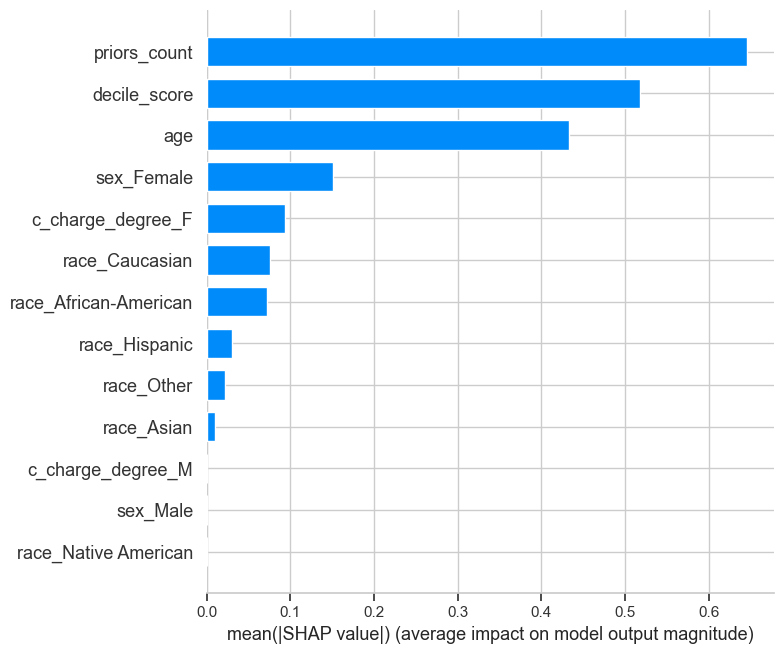

Global feature importance plot saved to figures/shap_bar.png


In [160]:


if shap_values is not None and X_test_shap is not None:
    try:
        plt.figure() 
        ax = plt.gca()
        shap.summary_plot(shap_values, X_test_shap, plot_type="bar", show=False)
        ax.grid(axis='y', visible=False)  # Remove y-axis grid
        plt.tight_layout()
        plt.savefig(f"figures/shap_bar.jpg", dpi=400)
        plt.show()
        print("Global feature importance plot saved to figures/shap_bar.png")
    except Exception as e_summary_plot:
        print(f"Error generating SHAP summary plot: {e_summary_plot}")
else:
    print("Skipping global feature importance plot: SHAP values or X_test_shap are missing.")

# ## 4. Top-5 Features Table



In [161]:


if shap_values is not None and X_test_shap is not None:
    try:
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        feature_names = X_test_shap.columns
        
        shap_summary_df = pd.DataFrame({
            'feature': feature_names,
            'mean_abs_shap': mean_abs_shap
        })
        
        top_5_features = shap_summary_df.sort_values(by='mean_abs_shap', ascending=False).head(5)
        
        print("\nTop-5 Features by Mean Absolute SHAP Value:")
        print(top_5_features)
    except Exception as e_top_features:
        print(f"Error calculating top-5 features: {e_top_features}")
else:
    print("Skipping top-5 features table: SHAP values or X_test_shap are missing.")

# ## 5. Single-Case Force Plot Explanation




Top-5 Features by Mean Absolute SHAP Value:
              feature  mean_abs_shap
1        priors_count       0.645684
0        decile_score       0.517272
2                 age       0.433598
9          sex_Female       0.151273
11  c_charge_degree_F       0.093452


SHAP force plot for sample 0 saved to figures/shap_force_sample_0.html.
Static SHAP force plot for sample 0 saved to figures/shap_force_sample_0.png

Chapter 4 (SHAP Explainability) processing complete.

Starting Conditional SHAP Analysis based on 'decile_score'...
Number of samples with decile_score >= 5: 668

Computing SHAP values for decile_score >= 5...


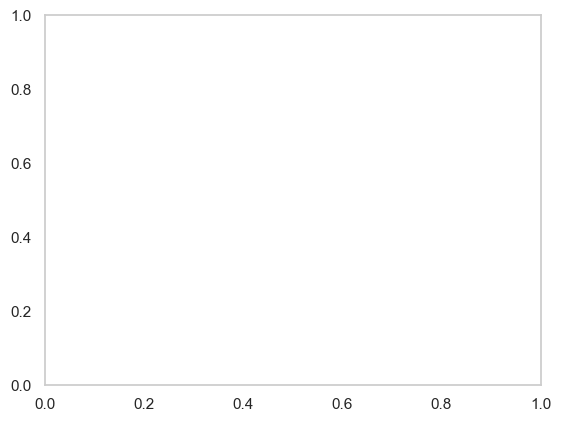

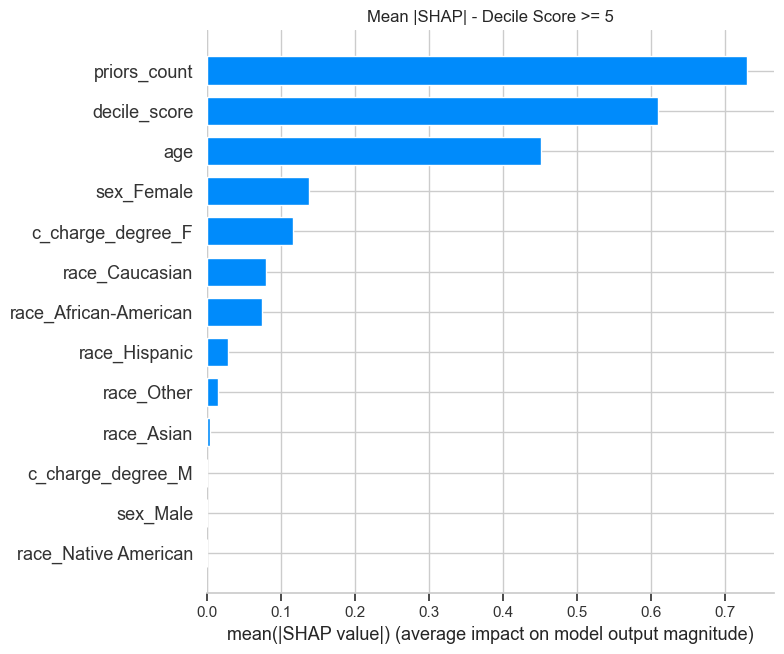

Conditional SHAP summary plot for decile_score >= 5 saved to figures/shap_bar_decile_above_5.png


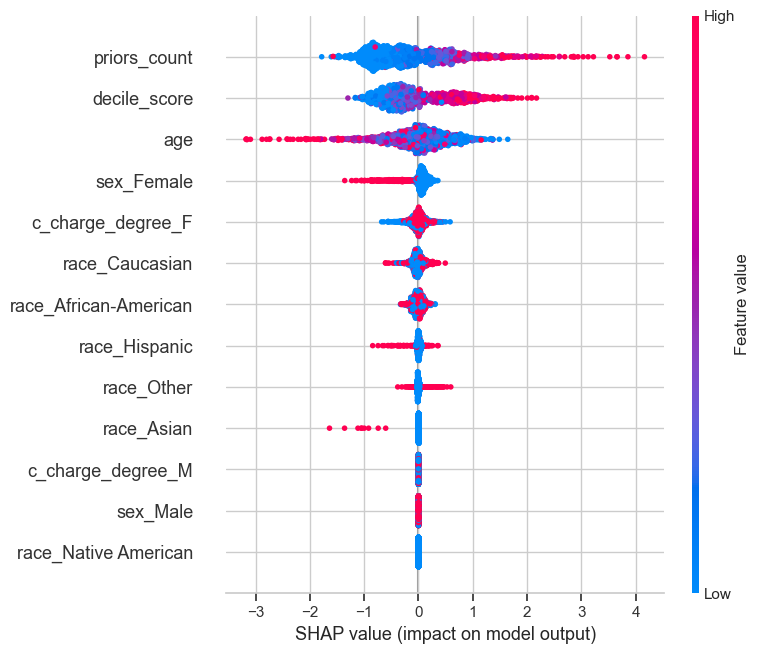

SHAP Beeswarm summary plot saved to figures/shap_beeswarm.png
Error generating SHAP dependence plot for decile_score: 'shap_values' must have the same number of columns as 'features'!


SHAP force plot for sample 0 saved to figures/shap_force_sample_0.html and displayed inline.

Chapter 4.1 (Enhanced Explainability Visualizations) processing complete.
Classification Report (Reweighing):
              precision    recall  f1-score   support

           0       0.73      0.89      0.80      1009
           1       0.69      0.42      0.52       583

    accuracy                           0.72      1592
   macro avg       0.71      0.66      0.66      1592
weighted avg       0.71      0.72      0.70      1592

ROC AUC (Reweighing): 0.7463
Reweighed logistic regression model saved to models/logreg_reweigh.pkl
Using existing 'model' (Logistic Regression) as baseline for ThresholdOptimizer.
ThresholdOptimizer fitted with 'equalized_odds' constraint.
Classification Report (ThresholdOptimizer - Equalized Odds):
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      1009
           1       0.59      0.50      0.54       583

   

In [162]:

if explainer is not None and shap_values is not None and X_test_shap is not None and len(X_test_shap) > 0:
    i = 0 # Index for the test sample
    if i < len(X_test_shap):
        try:
            # Ensure display is available from IPython.display
            shap.initjs() # Initialize JavaScript for force plots
            force_plot = shap.force_plot(
                explainer.expected_value,
                shap_values[i],
                X_test_shap.iloc[i],
                feature_names=X_test_shap.columns.tolist(),
                matplotlib=False,  # Use JavaScript for more control
                plot_cmap=["#ff0d57", "#1e88e5"],  # Use default colors to ensure compatibility
                text_rotation=0    # Use 0 rotation to prevent overlapping
            )
            # Save as HTML
            shap.save_html('figures/shap_force_sample_0.html', force_plot)
            print(f"SHAP force plot for sample {i} saved to figures/shap_force_sample_0.html.")
            # Additionally, save as a static PNG using matplotlib (white background)
            try:
                plt.figure()
                plt.grid(False)
                shap.plots.force(
                    explainer.expected_value,
                    shap_values[i],
                    X_test_shap.iloc[i],
                    matplotlib=True,
                    show=False,
                    feature_names=X_test_shap.columns.tolist()
                )
                plt.gcf().set_facecolor('white')
                ax = plt.gca()
                # Find and remove the f(x) text annotation
                for artist in ax.get_children():
                    if hasattr(artist, 'get_text') and 'f(x)' in str(artist.get_text()):
                        artist.set_visible(False)
                plt.tight_layout()
                plt.savefig(f"figures/shap_force_sample_0.jpg", dpi=400)
                plt.close()
                print(f"Static SHAP force plot for sample {i} saved to figures/shap_force_sample_0.png")
            except Exception as e_force_static:
                print(f"Error saving static SHAP force plot as PNG: {e_force_static}")
        except Exception as e_force:
            print(f"Error generating SHAP force plot for sample {i}: {e_force}")
    else:
        print(f"Test sample index {i} is out of bounds for X_test_shap with length {len(X_test_shap)}.")
else:
    print("Skipping single-case force plot: explainer, SHAP values, or X_test_shap are missing/empty.")

# %%
# End of Chapter 4
print("\nChapter 4 (SHAP Explainability) processing complete.")

# %% [markdown]
# ## 6. Conditional SHAP Analysis (Decile Score >= 5)
# This section explores how feature importance differs for individuals with a COMPAS decile score of 5 or greater.

# %%
if explainer is not None and X_test_shap is not None and 'decile_score' in X_test_shap.columns:
    print("\nStarting Conditional SHAP Analysis based on 'decile_score'...")

    # Filter X_test_shap based on decile_score
    X_test_above_5 = X_test_shap[X_test_shap['decile_score'] >= 5]

    print(f"Number of samples with decile_score >= 5: {len(X_test_above_5)}")

    if not X_test_above_5.empty:
        try:
            print("\nComputing SHAP values for decile_score >= 5...")
            shap_values_above_5 = explainer.shap_values(X_test_above_5)

            plt.figure()
            ax = plt.gca()
            shap.summary_plot(shap_values_above_5, X_test_above_5, plot_type="bar", show=False)
            ax.grid(axis='y', visible=False)  # Remove y-axis grid
            plt.title("Mean |SHAP| - Decile Score >= 5")
            plt.tight_layout()
            plt.savefig(f"figures/shap_bar_decile_above_5.jpg", dpi=400)
            plt.show()
            print("Conditional SHAP summary plot for decile_score >= 5 saved to figures/shap_bar_decile_above_5.png")
        except Exception as e_shap_above:
            print(f"Error during SHAP analysis for decile_score >= 5: {e_shap_above}")
    else:
        print("No samples found with decile_score >= 5. Skipping SHAP analysis for this subset.")
else:
    print("\nSkipping conditional SHAP analysis: explainer, X_test_shap, or 'decile_score' column is missing.")

# %%
# This empty In[] cell is just to mimic notebook structure if converted back.
# It doesn't affect python script execution.

# %% [markdown]
# # Chapter 4.1: Enhanced Explainability Visualizations

# %% [markdown]
# ## Setup: Ensure figures/ exists
# %%
import os

os.makedirs("figures", exist_ok=True)
from IPython.display import display  # Added for force_plot

# %% [markdown]
# ## 1. SHAP Summary (Beeswarm)
# Assumes `shap_values` and `X_test_shap` are available from previous cells.
# %%
if 'shap_values' in locals() and 'X_test_shap' in locals() and shap_values is not None and X_test_shap is not None:
    try:
        plt.figure() # Create a new figure to avoid overlap
        ax = plt.gca()
        shap.summary_plot(shap_values, X_test_shap, plot_type='dot', show=False)
        ax.grid(axis='y', visible=False)  # Remove y-axis grid
        plt.tight_layout()
        plt.tight_layout()
        plt.savefig(f"figures/shap_beeswarm.jpg", dpi=400)
        plt.show()
        print("SHAP Beeswarm summary plot saved to figures/shap_beeswarm.png")
    except Exception as e:
        print(f"Error generating SHAP beeswarm plot: {e}")
else:
    print("Skipping SHAP Beeswarm plot: shap_values or X_test_shap not available.")

# %% [markdown]
# ## 2. SHAP Dependence Plot by Race
# Assumes `shap_values`, `X_test_shap`, and `df` (original DataFrame) are available.
# %%
if 'shap_values' in locals() and 'X_test_shap' in locals() and 'df' in locals() and shap_values is not None and X_test_shap is not None:
    top_feature = 'decile_score'
    if top_feature in X_test_shap.columns:
        try:
            X_test_with_race = X_test_shap.copy()
            # Ensure indices align for correct race mapping
            if X_test_shap.index.isin(df.index).all():
                X_test_with_race['race'] = df.loc[X_test_shap.index, 'race']

                # Ensure 'race' is included as a feature column for interaction_index
                X_features_with_race = X_test_with_race.copy()  # Include race
                interaction_index = 'race'
                plt.figure() # Create a new figure
                shap.dependence_plot(
                    top_feature,
                    shap_values,
                    X_features_with_race,
                    interaction_index=interaction_index,
                    show=False
                )
                plt.tight_layout()
                plt.tight_layout()
                plt.savefig(f'figures/shap_dependence_{top_feature}_by_race.jpg', dpi=400)
                plt.show()
                print(f"SHAP dependence plot for {top_feature} by race saved to figures/shap_dependence_{top_feature}_by_race.png")
            else:
                print(f"Error in SHAP dependence plot: X_test_shap indices not fully in df.index. Cannot map race reliably.")

        except Exception as e:
            print(f"Error generating SHAP dependence plot for {top_feature}: {e}")
    else:
        print(f"Skipping SHAP dependence plot: top feature '{top_feature}' not in X_test_shap.columns.")
else:
    print("Skipping SHAP dependence plot: shap_values, X_test_shap, or df not available.")

# %% [markdown]
# ## 3. SHAP Force Plot for Sample 0
# Assumes `explainer`, `shap_values`, and `X_test_shap` are available.
# %%
if 'explainer' in locals() and 'shap_values' in locals() and 'X_test_shap' in locals() and explainer is not None and shap_values is not None and X_test_shap is not None:
    i = 0 # Index for the test sample
    if not X_test_shap.empty and i < len(X_test_shap):
        try:
            # Ensure display is available from IPython.display
            shap.initjs() # Initialize JavaScript for force plots
            
            force_plot = shap.force_plot(
                explainer.expected_value,
                shap_values[i],
                X_test_shap.iloc[i],
                feature_names=X_test_shap.columns.tolist(), # Pass as list
                matplotlib=False,  # Use JavaScript for more control
                plot_cmap=["#ff0d57", "#1e88e5"]  # Use default colors to ensure compatibility
            )
            
            # Display inline in notebook-like environments
            display(force_plot)
            
            # Save as HTML
            shap.save_html('figures/shap_force_sample_0.html', force_plot)
            print(f"SHAP force plot for sample {i} saved to figures/shap_force_sample_0.html and displayed inline.")
            
        except NameError as ne:
            if 'display' in str(ne):
                print("Error displaying SHAP force plot: `display` function not found. Ensure you are in an IPython environment and `from IPython.display import display` has been run.")
            else:
                print(f"Error generating SHAP force plot for sample {i}: {ne}")
        except Exception as e:
            print(f"Error generating SHAP force plot for sample {i}: {e}")
    else:
        print(f"Skipping SHAP force plot: X_test_shap is empty or sample index {i} is out of bounds.")
else:
    print("Skipping SHAP force plot: explainer, shap_values, or X_test_shap not available.")

# %%
print("\nChapter 4.1 (Enhanced Explainability Visualizations) processing complete.")

# %% [markdown]
# # Chapter 5: Mitigation Experiments

# Ensure models and figures directories exist
import os

import joblib
import matplotlib.pyplot as plt  # Included for consistency, though not directly used for plotting here
import numpy as np

# %%
import pandas as pd
from fairlearn.metrics import MetricFrame, equalized_odds_difference
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

# Assumptions:
# - df, X_train, X_test, y_train, y_test are available from previous chapters.
# - 'model' (original logistic regression model from Chapter 3) is available.
#   If not, it will be loaded or retrained in section 2.1.

os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True) # For saving summary table

# Define sensitive features for training and test sets
# These will be used by Fairlearn components.
# It's crucial that these Series align with y_train, y_test, X_train, X_test.
sensitive_features_train = df.loc[X_train.index, 'race']
sensitive_features_test = df.loc[X_test.index, 'race']


# %% [markdown]
# ## 1. Pre-processing: Reweighing (Kamiran & Calders)

# %% [markdown]
# ### 1.1 Setup and Transform (Compute Sample Weights)
# Compute reweighing sample weights manually per Kamiran & Calders
# %%
# Compute reweighing sample weights manually per Kamiran & Calders
import pandas as pd

train_df = pd.DataFrame({
    'sensitive': sensitive_features_train,
    'label': y_train
})
# Marginal probabilities
p_a = train_df['sensitive'].value_counts(normalize=True)
p_y = train_df['label'].value_counts(normalize=True)
# Joint probability P(A=a, Y=y)
p_ay = train_df.groupby(['sensitive','label']).size() / len(train_df)
# Compute sample weights: w_i = P(A=a)*P(Y=y)/P(A=a,Y=y)
sample_weights_train = train_df.apply(
    lambda row: (p_a.loc[row['sensitive']]*p_y.loc[row['label']] )/p_ay.loc[(row['sensitive'], row['label'])],
    axis=1
)

# %% [markdown]
# ### 1.2 Train Model with Sample Weights

# %%
logreg_reweigh = LogisticRegression(solver='liblinear', random_state=42)
# Fit the model on X_train, y_train, using the computed sample_weights_train
logreg_reweigh.fit(X_train, y_train, sample_weight=sample_weights_train)

# Predict on the original (untransformed) X_test
y_pred_reweigh = logreg_reweigh.predict(X_test)
y_pred_proba_reweigh = logreg_reweigh.predict_proba(X_test)[:, 1]

# %% [markdown]
# ### 1.3 Metrics and Save (Reweighing)

# %%
print("Classification Report (Reweighing):")
print(classification_report(y_test, y_pred_reweigh))

roc_auc_reweigh = roc_auc_score(y_test, y_pred_proba_reweigh)
print(f"ROC AUC (Reweighing): {roc_auc_reweigh:.4f}")

joblib.dump(logreg_reweigh, 'models/logreg_reweigh.pkl')
print("Reweighed logistic regression model saved to models/logreg_reweigh.pkl")

# %% [markdown]
# ## 2. Post-processing: ThresholdOptimizer with Equalized Odds

# %% [markdown]
# ### 2.1 Setup Baseline Model (Original Logistic Regression)
# This step ensures the original logistic model ('model') is available.
# It's assumed to be the one trained in Chapter 3.

# %%
# Check if 'model' is in scope and is a LogisticRegression instance.
# If not, load from disk or retrain as a fallback.
try:
    if 'model' not in locals() or not isinstance(model, LogisticRegression):
        print("Original logistic model ('model') not found or not a LogisticRegression instance. Attempting to load from 'models/logistic_model.pkl'.")
        model = joblib.load('models/logistic_model.pkl')
        if not isinstance(model, LogisticRegression): # Double check after loading
             raise TypeError("Loaded model is not a LogisticRegression.")
    print("Using existing 'model' (Logistic Regression) as baseline for ThresholdOptimizer.")
except (FileNotFoundError, TypeError, NameError) as e: # Added NameError for 'model' not defined
    print(f"Error with baseline model: {e}. Retraining original logistic model.")
    model = LogisticRegression(solver='liblinear', random_state=42)
    model.fit(X_train, y_train) # Train on original X_train, y_train without weights
    joblib.dump(model, 'models/logistic_model.pkl') # Save if retrained
    print("Retrained and saved original logistic model as 'models/logistic_model.pkl'.")


# %% [markdown]
# ### 2.2 Wrap with ThresholdOptimizer
# The ThresholdOptimizer is fitted on the training data using the pre-trained baseline model.

# %%
threshold_optimizer = ThresholdOptimizer(
    estimator=model,  # The pre-trained baseline logistic regression model
    constraints='equalized_odds',  # Target fairness constraint
    objective='accuracy_score',  # Optimization objective
    prefit=True,  # Indicates that the estimator 'model' is already fitted
    predict_method='predict_proba'
)

# Fit the ThresholdOptimizer. It learns new thresholds based on the baseline model's outputs.
threshold_optimizer.fit(X_train, y_train, sensitive_features=sensitive_features_train)
print("ThresholdOptimizer fitted with 'equalized_odds' constraint.")

# %% [markdown]
# ### 2.3 Predict and Evaluate (ThresholdOptimizer)

# %%
# Predict on X_test using the ThresholdOptimizer, providing sensitive features for the test set
y_pred_threshopt = threshold_optimizer.predict(X_test, sensitive_features=sensitive_features_test)

# Probabilities for AUC are typically from the underlying model, as ThresholdOptimizer adjusts decision thresholds.
y_pred_proba_threshopt_base = model.predict_proba(X_test)[:, 1]

print("Classification Report (ThresholdOptimizer - Equalized Odds):")
print(classification_report(y_test, y_pred_threshopt))

# Detailed FPR/FNR by race for ThresholdOptimizer
print("\nFPR/FNR by Race (ThresholdOptimizer - Equalized Odds):")
metrics_threshopt_grouped = []
for race_val in sorted(sensitive_features_test.unique()):
    mask = (sensitive_features_test == race_val)
    if sum(mask) > 0: # Ensure there are samples for this race group in the test set
        tn, fp, fn, tp = confusion_matrix(y_test[mask], y_pred_threshopt[mask], labels=[0,1]).ravel()
        fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr_val = fn / (fn + tp) if (fn + tp) > 0 else 0
        metrics_threshopt_grouped.append({'race': race_val, 'FPR': fpr_val, 'FNR': fnr_val, 'count': sum(mask)})
    else:
        metrics_threshopt_grouped.append({'race': race_val, 'FPR': np.nan, 'FNR': np.nan, 'count': 0})
print(pd.DataFrame(metrics_threshopt_grouped))

# %% [markdown]
# ## 3. Fairness Metrics & Comparison

# %% [markdown]
# ### 3.1 Construct Summary Table

# %%
# Predictions for the original (baseline) model, if not already generated for this specific y_test
y_pred_orig = model.predict(X_test)
y_pred_proba_orig = model.predict_proba(X_test)[:, 1]

# Helper function to compute and compile metrics for the summary table
def get_model_summary_metrics(y_true, y_pred, y_pred_proba, sensitive_features, model_name, races_to_report=['African-American', 'Caucasian']):
    accuracy = accuracy_score(y_true, y_pred)
    # AUC calculated from prediction probabilities
    auc = roc_auc_score(y_true, y_pred_proba) if y_pred_proba is not None else np.nan
    
    # Filter for 'African-American' and 'Caucasian' groups for Equalized Odds Difference
    mask_bw = sensitive_features.isin(['African-American', 'Caucasian'])
    y_true_bw = y_true[mask_bw]
    y_pred_bw = y_pred[mask_bw]
    sensitive_features_bw = sensitive_features[mask_bw]

    # Equalized Odds Difference using fairlearn.metrics
    # This considers the differences in FPR and TPR between the unprivileged and privileged groups.
    # If sensitive_features_bw is empty or has only one group, this might raise an error or return NaN.
    if len(sensitive_features_bw.unique()) > 1:
        eq_odds_diff = equalized_odds_difference(y_true_bw, y_pred_bw, sensitive_features=sensitive_features_bw)
    else:
        eq_odds_diff = np.nan # Or handle as appropriate if only one or no relevant groups present

    # Calculate FPR/FNR for specified groups to include in the table
    metrics_by_group = {}
    for race in races_to_report:
        mask = (sensitive_features == race)
        if sum(mask) > 0:
            tn, fp, fn, tp = confusion_matrix(y_true[mask], y_pred[mask], labels=[0,1]).ravel()
            metrics_by_group[f'FPR_{race}'] = fp / (fp + tn) if (fp + tn) > 0 else 0
            metrics_by_group[f'FNR_{race}'] = fn / (fn + tp) if (fn + tp) > 0 else 0
        else: # Handle case where a group might not be in the test set
            metrics_by_group[f'FPR_{race}'] = np.nan
            metrics_by_group[f'FNR_{race}'] = np.nan

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "AUC": auc,
        "Equalized Odds Difference": eq_odds_diff,
        f"FPR ({races_to_report[0]})": metrics_by_group.get(f'FPR_{races_to_report[0]}'),
        f"FPR ({races_to_report[1]})": metrics_by_group.get(f'FPR_{races_to_report[1]}'),
        f"FNR ({races_to_report[0]})": metrics_by_group.get(f'FNR_{races_to_report[0]}'),
        f"FNR ({races_to_report[1]})": metrics_by_group.get(f'FNR_{races_to_report[1]}'),
    }

all_model_metrics = []

# Metrics for the Original Logistic Regression Model
all_model_metrics.append(get_model_summary_metrics(y_test, y_pred_orig, y_pred_proba_orig, sensitive_features_test, "Original Logistic Regression"))

# Metrics for the Reweighing + Logistic Regression Model
all_model_metrics.append(get_model_summary_metrics(y_test, y_pred_reweigh, y_pred_proba_reweigh, sensitive_features_test, "Reweighing + Logistic Regression"))

# Metrics for the ThresholdOptimizer (on original Logistic Regression) Model
# For AUC, using the base model's probabilities (y_pred_proba_threshopt_base) as ThresholdOptimizer adjusts prediction thresholds.
all_model_metrics.append(get_model_summary_metrics(y_test, y_pred_threshopt, y_pred_proba_threshopt_base, sensitive_features_test, "ThresholdOptimizer (Eq. Odds)"))

summary_df = pd.DataFrame(all_model_metrics)

# %% [markdown]
# ### 3.2 Save/Print Table

# %%
print("\n--- Mitigation Techniques Summary ---")
# Ensure all columns are displayed
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
    print(summary_df)

# Save the summary table to a CSV file
summary_table_path = 'figures/mitigation_summary.csv'
summary_df.to_csv(summary_table_path, index=False)
print(f"\nSummary table saved to {summary_table_path}")

# %%
print("\nChapter 5 (Mitigation Experiments) processing complete.")

# %% [markdown]
# # Chapter 6: Model Comparison Summary
# This chapter provides a summary table comparing the fairness and accuracy metrics of the models evaluated throughout the analysis.

import numpy as np

# %%
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score

# The fairlearn.metrics.equalized_odds_difference function is imported in Chapter 5.
# If running this cell block independently and that import was missed, it would be needed:
# from fairlearn.metrics import equalized_odds_difference

print("\n--- Generating Model Comparison Summary Table ---")

# This code assumes that all necessary variables from previous chapters/cells are available in the global scope.
# Key variables expected:
# - y_test: True labels for the test set
# - X_test: Features for the test set (used for indexing into df)
# - df: The primary DataFrame containing all data including 'race' and 'decile_score'
# - sensitive_features_test: Series of race for the test set (df.loc[X_test.index, 'race'])
#
# - For COMPAS:
#   - y_pred_decile: Predictions based on decile_score >= 5
# - For Logistic Regression:
#   - y_pred: Predictions from the optimized logistic regression model
#   - y_pred_proba: Predicted probabilities from the logistic regression model
# - For XGBoost:
#   - y_pred_xgb: Predictions from the XGBoost model
#   - y_pred_proba_xgb: Predicted probabilities from the XGBoost model
# - For ThresholdOptimizer:
#   - y_pred_threshopt: Predictions from the ThresholdOptimizer
#   - y_pred_proba_threshopt_base: Predicted probabilities from the base model used with ThresholdOptimizer (Logistic Regression's probabilities)

summary_data_list = []

# --- Model 1: COMPAS (Rule: decile_score >= 5) ---
# Predictions y_pred_decile are from In[69b]
# df_test (df.loc[X_test.index])['decile_score'] for ROC AUC
compas_scores_for_auc = df.loc[X_test.index, 'decile_score']
acc_compas = accuracy_score(y_test, y_pred_decile)
roc_auc_compas = roc_auc_score(y_test, compas_scores_for_auc)

# Filter for Black vs. White for EOG calculation
mask_bw_compas = sensitive_features_test.isin(['African-American', 'Caucasian'])
y_test_bw_compas = y_test[mask_bw_compas]
y_pred_decile_bw = y_pred_decile[mask_bw_compas]
sensitive_features_test_bw_compas = sensitive_features_test[mask_bw_compas]
eog_compas = equalized_odds_difference(y_test_bw_compas, y_pred_decile_bw, sensitive_features=sensitive_features_test_bw_compas) if len(sensitive_features_test_bw_compas.unique()) > 1 else np.nan

summary_data_list.append({
    'Model': 'COMPAS (Rule)',
    'Accuracy': acc_compas,
    'ROC AUC': roc_auc_compas,
    'Equalized Odds Gap': eog_compas
})

# --- Model 2: Logistic Regression ---
# Predictions y_pred and probabilities y_pred_proba are from In[69]
acc_lr = accuracy_score(y_test, y_pred)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba) # y_pred_proba is y_proba_lr in In[69]

# Filter for Black vs. White for EOG calculation
mask_bw_lr = sensitive_features_test.isin(['African-American', 'Caucasian'])
y_test_bw_lr = y_test[mask_bw_lr]
y_pred_bw_lr = y_pred[mask_bw_lr]
sensitive_features_test_bw_lr = sensitive_features_test[mask_bw_lr]
eog_lr = equalized_odds_difference(y_test_bw_lr, y_pred_bw_lr, sensitive_features=sensitive_features_test_bw_lr) if len(sensitive_features_test_bw_lr.unique()) > 1 else np.nan

summary_data_list.append({
    'Model': 'Logistic Regression',
    'Accuracy': acc_lr,
    'ROC AUC': roc_auc_lr,
    'Equalized Odds Gap': eog_lr
})

# --- Model 3: XGBoost ---
# Predictions y_pred_xgb and probabilities y_pred_proba_xgb are from In[69b]
acc_xgb = accuracy_score(y_test, y_pred_xgb)
roc_auc_xgb_val = roc_auc_score(y_test, y_pred_proba_xgb) # This is roc_auc_xgb in In[69b]

# Filter for Black vs. White for EOG calculation
mask_bw_xgb = sensitive_features_test.isin(['African-American', 'Caucasian'])
y_test_bw_xgb = y_test[mask_bw_xgb]
y_pred_xgb_bw = y_pred_xgb[mask_bw_xgb]
sensitive_features_test_bw_xgb = sensitive_features_test[mask_bw_xgb]
eog_xgb = equalized_odds_difference(y_test_bw_xgb, y_pred_xgb_bw, sensitive_features=sensitive_features_test_bw_xgb) if len(sensitive_features_test_bw_xgb.unique()) > 1 else np.nan

summary_data_list.append({
    'Model': 'XGBoost',
    'Accuracy': acc_xgb,
    'ROC AUC': roc_auc_xgb_val,
    'Equalized Odds Gap': eog_xgb
})

# --- Model 4: ThresholdOptimizer (Equalized Odds) ---
# Predictions y_pred_threshopt from Chapter 5, Section 2.3
# Probabilities y_pred_proba_threshopt_base (from base LR model) from Chapter 5, Section 3.1
acc_threshopt = accuracy_score(y_test, y_pred_threshopt)
roc_auc_threshopt = roc_auc_score(y_test, y_pred_proba_threshopt_base)

# Filter for Black vs. White for EOG calculation
mask_bw_threshopt = sensitive_features_test.isin(['African-American', 'Caucasian'])
y_test_bw_threshopt = y_test[mask_bw_threshopt]
y_pred_threshopt_bw = y_pred_threshopt[mask_bw_threshopt]
sensitive_features_test_bw_threshopt = sensitive_features_test[mask_bw_threshopt]
eog_threshopt = equalized_odds_difference(y_test_bw_threshopt, y_pred_threshopt_bw, sensitive_features=sensitive_features_test_bw_threshopt) if len(sensitive_features_test_bw_threshopt.unique()) > 1 else np.nan

summary_data_list.append({
    'Model': 'ThresholdOptimizer (Eq. Odds)',
    'Accuracy': acc_threshopt,
    'ROC AUC': roc_auc_threshopt,
    'Equalized Odds Gap': eog_threshopt
})

summary_df_final_comparison = pd.DataFrame(summary_data_list)

print("\n--- Model Comparison Summary (Markdown Table) ---")
# Using tablefmt="grid" for a nicely formatted Markdown table.
# If this causes issues in a specific environment, "pipe" or other formats can be used.
print(summary_df_final_comparison.to_markdown(index=False, tablefmt="grid"))

print("\nChapter 6 (Model Comparison Summary) processing complete.")

# %%
# End of script addition

